<a id="section-one"></a>
# **Synopsis**:

- I attempted to **"bring to life"** recent deep learning models used in time series forecasting (that is, recent research papers) by implementing them using the competition dataset,and I am confident that this will excite you.  

- There have been research papers that have failed to work, as well as research papers that have **functioned brilliantly** on the competition dataset, such as the **STAM model** that I have already implemented here [STAM Implementation](https://www.kaggle.com/code/abireltaief/stam-spatiotemporal-attention-model-implementation).  

- A while ago I tried to focus on a model that I loved : **Conditional time series forecasting with convolutional neural networks**, which was an adaptation of the **Google WaveNet** to Times series. The following is a link to the paper: [WaveNet for Time Series!](https://arxiv.org/pdf/1703.04691.pdf)

- Surprisingly, the **Adapted Google WaveNet** model (as suggested by its authors) works well on time series forecasting, particularly on the competition dataset.

In this Notebook, I implement it (along with some lovely visuals to make it easier…)
I also provide some interesting links that I used:

- The **original WaveNet Model** (of Google) : [WaveNet paper](https://www.researchgate.net/publication/308026508_WaveNet_A_Generative_Model_for_Raw_Audio)
- **Forecasting Financial Time Series through Causal and Dilated Convolutional Neural Networks** paper [here](https://mdpi-res.com/d_attachment/entropy/entropy-22-01094/article_deploy/entropy-22-01094.pdf?version=1601376469): This one digs into causal and dilated convolutions (the foundation of the WaveNet model).


<a id="section-two"></a>
# **Loading Data**:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn import preprocessing

In [ ]:
train_path = '../input/smart-homes-temperature-time-series-forecasting/train.csv'
test_path = '../input/smart-homes-temperature-time-series-forecasting/test.csv'

In [ ]:
df = pd.read_csv(train_path)
df.head()

,Id,Date,Time,CO2_(dinning-room),CO2_room,Relative_humidity_(dinning-room),Relative_humidity_room,Lighting_(dinning-room),Lighting_room,Meteo_Rain,Meteo_Sun_dusk,Meteo_Wind,Meteo_Sun_light_in_west_facade,Meteo_Sun_light_in_east_facade,Meteo_Sun_light_in_south_facade,Meteo_Sun_irradiance,Outdoor_relative_humidity_Sensor,Day_of_the_week,Indoor_temperature_room
0,0,13/03/2012,11:45,216.560,221.920,39.9125,42.4150,81.6650,113.520,0.0,623.360,1.42625,9690.24,12604.20,95436.8,758.880,48.3750,2.0,17.8275
1,1,13/03/2012,12:00,219.947,220.363,39.9267,42.2453,81.7413,113.605,0.0,623.211,1.59200,11022.00,10787.20,95436.8,762.069,47.8080,2.0,18.1207
2,2,13/03/2012,12:15,219.403,218.933,39.7720,42.2267,81.4240,113.600,0.0,622.656,1.89133,13960.50,9669.63,95398.6,766.251,47.4320,2.0,18.4367
3,3,13/03/2012,12:30,218.613,217.045,39.7760,42.0987,81.5013,113.344,0.0,622.571,1.82800,18511.20,9648.13,95360.3,766.037,47.0240,2.0,18.7513
4,4,13/03/2012,12:45,217.714,216.080,39.7757,42.0686,81.4657,113.034,0.0,622.400,2.36071,26349.00,9208.32,95354.9,762.743,45.4743,2.0,19.0414


In [ ]:
df.drop(['Id','Date','Time','Day_of_the_week'],axis=1,inplace=True)

In [ ]:
df.dtypes

CO2_(dinning-room)                  float64
CO2_room                            float64
Relative_humidity_(dinning-room)    float64
Relative_humidity_room              float64
Lighting_(dinning-room)             float64
Lighting_room                       float64
Meteo_Rain                          float64
Meteo_Sun_dusk                      float64
Meteo_Wind                          float64
Meteo_Sun_light_in_west_facade      float64
Meteo_Sun_light_in_east_facade      float64
Meteo_Sun_light_in_south_facade     float64
Meteo_Sun_irradiance                float64
Outdoor_relative_humidity_Sensor    float64
Indoor_temperature_room             float64
dtype: object

In [ ]:
df = df.astype(dtype="float32")
df.dtypes

CO2_(dinning-room)                  float32
CO2_room                            float32
Relative_humidity_(dinning-room)    float32
Relative_humidity_room              float32
Lighting_(dinning-room)             float32
Lighting_room                       float32
Meteo_Rain                          float32
Meteo_Sun_dusk                      float32
Meteo_Wind                          float32
Meteo_Sun_light_in_west_facade      float32
Meteo_Sun_light_in_east_facade      float32
Meteo_Sun_light_in_south_facade     float32
Meteo_Sun_irradiance                float32
Outdoor_relative_humidity_Sensor    float32
Indoor_temperature_room             float32
dtype: object

<a id="section-three"></a>
# **Splitting Data & Visualizations:**

In [ ]:
percentage = 0.8
splitting_time = int(len(df) * percentage)

train_x = np.array(df.values[:splitting_time],dtype=np.float32)
val_x = np.array(df.values[splitting_time:],dtype=np.float32)

print("train dataset size : %d" %len(train_x))
print("validation dataset size : %d" %len(val_x))

train dataset size : 2211
validation dataset size : 553


In [ ]:
# Construction of the series

train_x = tf.convert_to_tensor(train_x)
test_x = tf.convert_to_tensor(val_x)

scaler = preprocessing.MinMaxScaler()
scaler.fit(train_x)

train_x_norm = scaler.transform(train_x)
val_x_norm = scaler.transform(val_x)

2022-05-04 08:52:30.044613: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 08:52:30.047319: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-04 08:52:30.047353: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-04 08:52:30.047379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (98f2c6fb6088): /proc/driver/nvidia/version does not exist
2022-05-04 08:52:30.050545: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

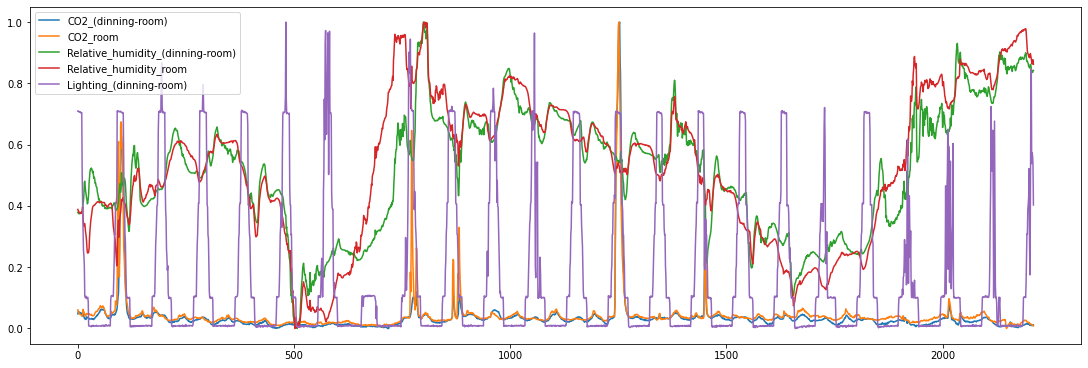

In [ ]:
# Displaying some scaled series
cols = list(df.columns)

fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(5):
  ax.plot(df.index[:splitting_time].values,train_x_norm[:,i], label= cols[i])
ax.legend()
plt.show()

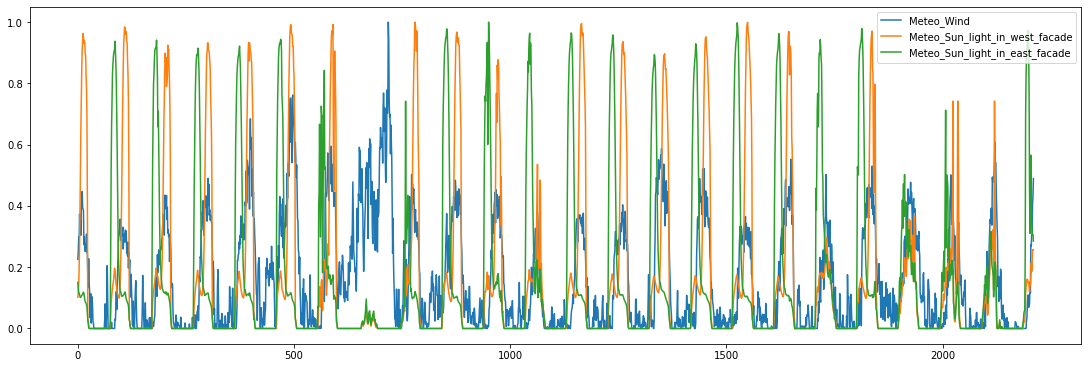

In [ ]:
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
for i in range(8,11):
  ax.plot(df.index[:splitting_time].values,train_x_norm[:,i], label= cols[i])
ax.legend()
plt.show()

<a id="section-four"></a>
# **Multivariate WaveNet Model for Time Series: Implementation (MultiStep forecasting)**

**Reminder:**   
The papers I used are:
- **Conditional time series forecasting with convolutional neural networks**: [WaveNet for Time Series!](https://arxiv.org/pdf/1703.04691.pdf)
- The **original WaveNet Model** (of Google) : [WaveNet paper](https://www.researchgate.net/publication/308026508_WaveNet_A_Generative_Model_for_Raw_Audio)
- **Forecasting Financial Time Series through Causal and Dilated Convolutional Neural Networks** paper [here](https://mdpi-res.com/d_attachment/entropy/entropy-22-01094/article_deploy/entropy-22-01094.pdf?version=1601376469): This one digs into causal and dilated convolutions (the foundation of the WaveNet model).

**Note**:    

First, Igive you **some insight** into the implementation foundations I used **(using my own words )**.

**1-Causal Convolution**
- Causal convolution enables us to keep the data in the correct order (no violation of the order in which the data is modeled).
- Predictions are **sequential**: After each prediction, the predicted value is **returned as input** (while shifting the moving window...)
- During the training phase, computations can be parallelized.

**2-Dilated Convolution**
- Allows to increase the length of the sequence (window size) without increasing the number of hidden layers
- The model uses dilations of size 1, 2, 4, 8, 16, 32, 64, …, 512, etc.

**3-WaveNet for Time Series**
- To adapt the WaveNet model (original version of Google) to time series forecasting, **several changes have been done**.
- In fact, **ReLU** (rather than **tanh** and **sigmoid**, as in the original WaveNet model for audio data) has been used to replace the activation functions.
- Because the audio data is **discrete data**, the original WaveNet's output is predicted using a **Softmax**, but with time series, **linear function** followed by **convoltions (1x1)** were utilized.  

For more details, see the papers I provided above.

**4-Many Architectures could be used**
- **Conditional WaveNet** for time series is the one that takes into account the other **exogenous series** "covariates" (as well as the **target series**).
- There are two **conditional architectures**: I will use (as recommended in the papers I provided), the **second architecture** as shown in the **figure below**. It should be noted that the **first architecture** is a **univariate WaveNet for time series**, which only considers the target series (not the exogenous serious).

![0_Abir_Conditional Wavenet (Multivariate).PNG](attachment:10f359ca-c5e9-4104-beb1-9af11e9f1278.PNG)

**Visuals**
- First, for the sake of simplicity and to understand the principle of dilated and causal convolution, I provide a detailed visual of the **univariate WaveNet** (using only the **target series** for predictions).  

- Then I provide a detailed visual of the architecture that I will implement: **Conditional WaveNet (or Multivariate WaveNet)**, using both exogenous and target series.

- **Note**:

These visuals were **created by me** (I used some backgrounds to make them, like as the dilated convolutions(...), from the source papers cited previously and in the references, which you may check for yourself).

- **Univariate WaveNet for Time Series**

![1_Abir_WaveNet Univariate Model.jpg](attachment:686c8c5e-e1fc-443a-a66e-165e6e2b0802.jpg)

- **Multivariate WaveNet (Conditional WaveNet for Time Series)**

![2_Abir_WaveNet_Multivariate.png](attachment:d4341dbc-d559-434a-9e30-58ea8314260e.png)

In [ ]:
def model_wavenet_timeseries(len_seq, len_out, dim_exo, nb_filters, dim_filters, dilation_depth, use_bias, res_l2, final_l2,batch_size):
  input_shape_exo = tf.keras.Input(shape=(len_seq, dim_exo), name='input_exo')
  input_shape_target = tf.keras.Input(shape=(len_seq, 1), name='input_target')

  input_exo = input_shape_exo
  input_target = input_shape_target

  outputs = []

  # 1st loop: I'll be making multi-step predictions (every prediction will serve as input for the second prediction, when I move the window size...).
  for t in range(len_out):

    # Causal convolution for the 1st input: exogenous series
    # out_exo : (batch_size,len_seq,dim_exo)
    out_exo = K.temporal_padding(input_exo, padding=((dim_filters - 1), 0)) #To keep the same len_seq for the hidden layers
    out_exo = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=dim_filters,dilation_rate=1,use_bias=True,activation=None,
                              name='causal_convolution_exo_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(out_exo)

    # Causal convolution for the 2nd input: target series
    # out_target : (batch_size,len_seq,1)
    out_target = K.temporal_padding(input_target, padding=((dim_filters - 1), 0))#To keep the same len_seq for the hidden layers
    out_target = tf.keras.layers.Conv1D(filters=nb_filters, kernel_size=dim_filters,dilation_rate=1,use_bias=True,activation=None,
                              name='causal_convolution_target_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(out_target)

    # Frist Layer #1 (See visual Above)
    # Dilated Convolution (1st Layer #1): part of exogenous series(see visual above)
    # skip_exo : (batch_size,len_seq,dim_exo)
    # first_out_exo (the same as skip_exo, before adding the residual connection): (batch_size, len_seq, dim_exo)
    skip_outputs = []
    z_exo = K.temporal_padding(out_exo, padding=(2*(dim_filters - 1), 0))
    z_exo = tf.keras.layers.Conv1D(filters=nb_filters,kernel_size=dim_filters,dilation_rate=2,use_bias=True,activation="relu",
                              name='dilated_convolution_exo_1_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)

    skip_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)
    first_out_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_exo)

    # Dilated Convolution (1st Layer #1): part of target series(see visual above)
    # skip_target : (batch_size,len_seq,1)
    # first_out_target (the same as skip_target, before adding the residual connection): (batch_size, len_seq,1)
    z_target = K.temporal_padding(out_target, padding=(2*(dim_filters - 1), 0))
    z_target = tf.keras.layers.Conv1D(filters=nb_filters,kernel_size=dim_filters,dilation_rate=2,use_bias=True,activation="relu",
                              name='dilated_convolution_target_1_%i' %t, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_target)
    skip_target = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_target)
    first_out_target = tf.keras.layers.Conv1D(1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z_target)

    # Concatenation of the skip_exo & skip_target AND Saving them as we go through the 1st for loop (through len_seq)
    # skip_exo : (batch_size,len_seq,dim_exo)
    # skip_target : (batch_size,len_seq,1)
    # The concatenation of skip_exp & skip_target : (batch_size,len_seq,dim_exo+1)
    skip_outputs.append(tf.concat([skip_exo,skip_target],axis=2))

    # Adding the Residual connections of the exogenous series & target series to inputs
    # res_exo_out : (batch_size,len_seq,dim_exo)
    # res_target_out : (batch_size,len_seq,1)
    res_exo_out = tf.keras.layers.Add()([input_exo, first_out_exo])
    res_target_out = tf.keras.layers.Add()([input_target, first_out_target])

    # Concatenation of the updated outputs (after having added the residual connections)
    # out_concat : (batch_size,len_seq,dim_exo+1)
    out_concat = tf.concat([res_exo_out, res_target_out],axis=2)
    out = out_concat

    # From 2nd Layer Layer#2 to Final Layer (Layer #L): See Visual above
    # 2nd loop: inner loop (Going through all the intermediate layers)
    # Intermediate dilated convolutions
    for i in range(2, dilation_depth + 1):
      z = K.temporal_padding(out_concat, padding=(2**i * (dim_filters - 1), 0)) # To keep the same len_seq
      z = tf.keras.layers.Conv1D(filters=nb_filters,kernel_size=dim_filters,dilation_rate=2**i,use_bias=True,activation="relu",
                              name='dilated_convolution_%i_%i' %(i,t), kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

      skip_x = tf.keras.layers.Conv1D(dim_exo+1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)
      first_out_x = tf.keras.layers.Conv1D(dim_exo+1, 1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(res_l2))(z)

      res_x = tf.keras.layers.Add()([out, first_out_x])  #(batch_size,len_seq,dim_exo+1)
      out = res_x
      skip_outputs.append(skip_x)                        #(batch_size,len_seq,dim_exo+1)

    # Adding intermediate outputs of all the layers (See Visual above)
    out = tf.keras.layers.Add()(skip_outputs)            #(batch_size,len_seqe,dim_exo+1)

    # Output Layer (exogenous series & target series)
    # outputs : (batch_size,1,1) # The predcition Y
    # out_f_exo (will be used to Adjust the input for the following prediction, see below) : (batch_size,len_seq,dim_exo)
    out = tf.keras.layers.Activation('linear', name="output_linear_%i" %t)(out)
    out_f_target = tf.keras.layers.Conv1D(1, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(final_l2))(out)
    out_f_exo = tf.keras.layers.Conv1D(dim_exo, 1, padding='same', kernel_regularizer=tf.keras.regularizers.l2(final_l2))(out)
    outputs.append(out_f_target[:,-1:,:])

    # Adjusting the entry of exogenous series,for the following prediction (of MultiStep predictions): see the 1st loop
    # First: concatenate the previous exogenous series input with the final exo_prediction(current exo_prediction)
    input_exo = tf.concat([input_exo, out_f_exo[:,-1:,:]],axis=1)
    # Second, shift the moving window (of len_seq size) by one
    input_exo = tf.slice(input_exo,[0,1,0],[batch_size,input_shape_exo.shape[1],dim_exo])

    # Adjusting the entry of target series,for the following prediction (of MultiStep predictions): see the 1st loop
    # First: concatenate the previous target series input with the final prediction(current prediction)
    input_target = tf.concat([input_target,out_f_target[:,-1:,:]],axis=1)
    # Second, shift the moving window (of len_seq size) by one
    input_target = tf.slice(input_target,[0,1,0],[batch_size,input_shape_target.shape[1],1])

  outputs = tf.convert_to_tensor(outputs)             # (len_out,batch_size,1,1)
  outputs = tf.squeeze(outputs,-1)                    # (len_out,batch_size,1)
  outputs = tf.transpose(outputs,perm=[1,0,2])        # (batch_size,len_out,1)

  model = tf.keras.Model([input_shape_exo,input_shape_target], outputs)
  return model

<a id="section-five"></a>
# **Model Creation**

In [ ]:
def compute_len_seq(dilation_depth):
  return (2 ** dilation_depth * 2)

In [ ]:
nb_filters = 96
dim_filters = 2
dilation_depth = 4     # len_seq = 32
use_bias = False
res_l2 = 0
final_l2 = 0

batch_size = 128
len_out = 5
dim_exo = 14

len_seq = compute_len_seq(dilation_depth)
print(len_seq)

model = model_wavenet_timeseries(len_seq, len_out, dim_exo, nb_filters, dim_filters, dilation_depth, use_bias, res_l2, final_l2,batch_size=batch_size)
model.summary()

32
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_exo (InputLayer)          [(None, 32, 14)]     0                                            
__________________________________________________________________________________________________
input_target (InputLayer)       [(None, 32, 1)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad (TFOpLambda)   (None, 33, 14)       0           input_exo[0][0]                  
__________________________________________________________________________________________________
tf.compat.v1.pad_1 (TFOpLambda) (None, 33, 1)        0           input_target[0][0]               
___________________________________________________________________________________________

<a id="section-six"></a>
# **Datasets creation**

In [ ]:
# This is required for Model implementation (for more information, see the Model Architecture Above).

def prepare_dataset_XY(seriesx, seriesy, len_seq, len_out, batch_size,shift):
  '''
  A function for creating a dataset from time series data as follows:
  X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
       (Y1,Y2,...,YT)}
  Y = YT+1
  seriesx-- Exogenous series, shape: (Tin, number_of_exogenous_series) with Tin: length of the time series
  seriesy-- Target series, shape: (Tin, 1)
  len_seq-- Sequence length: integer
  len_out-- Length of the predicted sequence (output): integer
  shift-- The window offset: integer
  batch_size-- Size of the batch: integer

  '''
  # Exogenous series
  # ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T),....)
  dataset_x = tf.data.Dataset.from_tensor_slices(seriesx)
  dataset_x = dataset_x.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_x = dataset_x.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_x = dataset_x.map(lambda x: x[0:len_seq][:,:]) # shape:[[ ]]
  dataset_x = dataset_x.batch(batch_size, drop_remainder=True).prefetch(1) # shape: [[[]]] (adding the batch_size)

  # The target series
  # (Y1,Y2,...,YT)
  dataset_y = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_y = dataset_y.window(len_seq+len_out, shift = shift, drop_remainder=True)
  dataset_y = dataset_y.flat_map(lambda x: x.batch(len_seq+len_out))
  dataset_y = dataset_y.map(lambda x: x[0:len_seq][:,:])
  dataset_y = dataset_y.batch(batch_size, drop_remainder=True).prefetch(1)

  # Y = YT+1 (the values to predict)
  dataset_ypred = tf.data.Dataset.from_tensor_slices(seriesy)
  dataset_ypred = dataset_ypred.window(len_seq+len_out+1, shift=shift, drop_remainder=True)
  dataset_ypred = dataset_ypred.flat_map(lambda x: x.batch(len_seq+len_out+1))
  dataset_ypred = dataset_ypred.map(lambda x: (x[0:len_seq+1][-len_out:,:]))
  dataset_ypred = dataset_ypred.batch(batch_size, drop_remainder=True).prefetch(1)

  dataset = tf.data.Dataset.zip((dataset_x, dataset_y))
  dataset = tf.data.Dataset.zip((dataset, dataset_ypred))
  return dataset

In [ ]:
# Example (Simple example for breaking down the function)

X1 = np.linspace(1,100,100) # 3 exogenous series
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100) # target series

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

series_x = tf.concat([X1,X2,X3], axis=1)
series_y = Y
print(series_x.shape)
print(series_y.shape)

(100, 3)
(100, 1)


In [ ]:
len_seq = 10
len_out = 1
shift = 1
batch_size = 1

dataset_example = prepare_dataset_XY(series_x, series_y, len_seq, len_out, batch_size,shift)

In [ ]:
for element in dataset_example.take(1):
  print("Exogenous series: ")
  print(element[0][0])
  print("----------------------")
  print("Target series: ")
  print(element[0][1])
  print("======================")
  print("Value to predict: ")
  print(element[1])

Exogenous series: 
tf.Tensor(
[[[  1. 101. 201.]
  [  2. 102. 202.]
  [  3. 103. 203.]
  [  4. 104. 204.]
  [  5. 105. 205.]
  [  6. 106. 206.]
  [  7. 107. 207.]
  [  8. 108. 208.]
  [  9. 109. 209.]
  [ 10. 110. 210.]]], shape=(1, 10, 3), dtype=float64)
----------------------
Target series: 
tf.Tensor(
[[[301.]
  [302.]
  [303.]
  [304.]
  [305.]
  [306.]
  [307.]
  [308.]
  [309.]
  [310.]]], shape=(1, 10, 1), dtype=float64)
Value to predict: 
tf.Tensor([[[311.]]], shape=(1, 1, 1), dtype=float64)


2022-05-04 08:52:35.657420: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-04 08:52:35.662660: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


In [ ]:
# The characteristics of the dataset I want to create

batch_size = 128
len_out = 5
len_seq = compute_len_seq(dilation_depth)
shift=1

# Dataset creation
dataset = prepare_dataset_XY(train_x_norm[:,0:-1], train_x_norm[:,-1:], len_seq, len_out, batch_size, shift)
dataset_val = prepare_dataset_XY(val_x_norm[:,0:-1], val_x_norm[:,-1:], len_seq, len_out, batch_size, shift)

In [ ]:
print(len(list(dataset.as_numpy_iterator())))
print(("---------------"))
for element in dataset.take(1):
  print(element[0][0].shape)
  print(element[0][1].shape)
  print(element[1].shape)

16
---------------
(128, 32, 14)
(128, 32, 1)
(128, 5, 1)


In [ ]:
print(len(list(dataset_val.as_numpy_iterator())))
print(("---------------"))
for element in dataset.take(1):
  print(element[0][0].shape)
  print(element[0][1].shape)
  print(element[1].shape)

4
---------------
(128, 32, 14)
(128, 32, 1)
(128, 5, 1)


<a id="section-seven"></a>
# **Datasets Preparation**

**1- Training dataset preparation**

In [ ]:
X1 = []
X2 = []

# Extracting x and y from the dataset
x,y = tuple(zip(*dataset)) #x: 16x((BS,32,14),(BS,32,1)) with BS= batch_size
                           #y: 16x(BS,5,1)
for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1])

X1 = np.asarray(X1, dtype = np.float32) # (16,BS,32,14)
X2 = np.asarray(X2, dtype = np.float32) # (16,BS,32,1)
y =  np.asarray(y, dtype= np.float32)    # (16,BS,5,1)

# Reshaping them
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1], X1.shape[2], X1.shape[3])) # (16,BS,32,14) --> (16xBS,32,14)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1], X2.shape[2], X2.shape[3])) # (16,BS,32,1)  --> (16xBS,32,1)

x_train = [X1,X2]
y_train = np.reshape(y,(y.shape[0]*y.shape[1], y.shape[2], y.shape[3])) # (16,BS,5,1) --> (16xBS,5,1)

print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)

(2048, 32, 14)
(2048, 32, 1)
(2048, 5, 1)


**2- Validation dataset preparation**

In [ ]:
# Extracting x and y from the validation dataset
X1 =[]
X2 =[]
x,y = tuple(zip(*dataset_val))

for i in range(len(x)):
  X1.append(x[i][0])
  X2.append(x[i][1])

X1 = np.asarray(X1,dtype=np.float32)
X2 = np.asarray(X2, dtype = np.float32)
y = np.asarray(y, dtype= np.float32)

# Reshaping them
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1], X1.shape[2], X1.shape[3]))
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1], X2.shape[2], X2.shape[3]))

x_val = [X1,X2]
y_val = np.reshape(y,(y.shape[0]*y.shape[1], y.shape[2], y.shape[3]))

print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)

(512, 32, 14)
(512, 32, 1)
(512, 5, 1)


<a id="section-eight"></a>
# **Train the Model with TPU:**

In [ ]:
# detect and initialize the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))

2022-05-04 08:52:38.783236: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 08:52:38.804888: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-04 08:52:38.804945: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-05-04 08:52:38.820554: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-05-04 08:52:38.820609: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-05-04 08:52:38.821320: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


In [ ]:
max_periods = 1000
# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

with tpu_strategy.scope():
    model = model_wavenet_timeseries(len_seq, len_out, dim_exo, nb_filters, dim_filters, dilation_depth, use_bias, res_l2, final_l2, batch_size=int(batch_size/8))
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.005,
      decay_steps=50,
      decay_rate=0.01)
    opt=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    CheckPoint = tf.keras.callbacks.ModelCheckpoint("weights_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')
    model.compile(loss="mse", optimizer=opt, metrics="mse")
    history = model.fit(x=[x_train[0],x_train[1]],y=y_train, validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periods,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)],batch_size=batch_size)




Epoch 1/1000
16/16 [==============================] - 27s 265ms/step - loss: 4.6943 - mse: 4.6943 - val_loss: 0.0699 - val_mse: 0.0699

Epoch 00001: loss improved from inf to 2.23763, saving model to weights_train.hdf5
Epoch 2/1000
16/16 [==============================] - 1s 50ms/step - loss: 0.0400 - mse: 0.0400 - val_loss: 0.0203 - val_mse: 0.0203

Epoch 00002: loss improved from 2.23763 to 0.03179, saving model to weights_train.hdf5
Epoch 3/1000
16/16 [==============================] - 1s 49ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0076 - val_mse: 0.0076

Epoch 00003: loss improved from 0.03179 to 0.00943, saving model to weights_train.hdf5
Epoch 4/1000
16/16 [==============================] - 1s 49ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0056 - val_mse: 0.0056

Epoch 00004: loss improved from 0.00943 to 0.00438, saving model to weights_train.hdf5
Epoch 5/1000
16/16 [==============================] - 1s 51ms/step - loss: 0.0029 - mse: 0.0029 - val_loss: 0.0046 - v

Text(0.5, 1.0, 'Evolution of the loss')

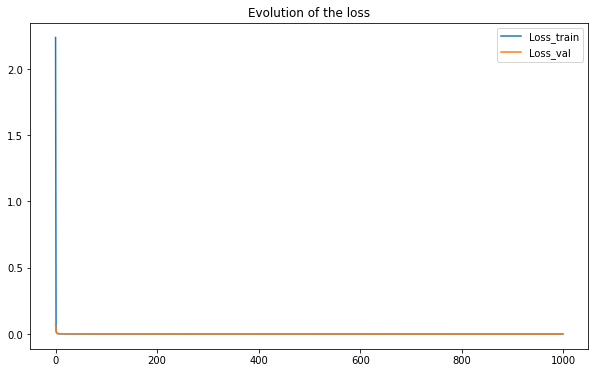

In [ ]:
# The evolution of loss during the training
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(loss_train)),loss_train, label="Loss_train")
plt.plot(np.arange(0,len(loss_train)),loss_val, label ="Loss_val")
plt.legend()

plt.title("Evolution of the loss")

<a id="section-nine"></a>
# **Predictions using the trained Adapted Google WaveNet for Time Series(MultiStep):**

In [ ]:
# I saved the best weights on the Kaggle/Output by using the ModelCheckPoint callback during the training phase.
model = model_wavenet_timeseries(len_seq, len_out, dim_exo, nb_filters, dim_filters, dilation_depth, use_bias, res_l2, final_l2,batch_size=batch_size)
model.load_weights("./weights_train.hdf5")

In [ ]:
pred_train = model.predict((x_train[0],x_train[1]),verbose=1,batch_size=batch_size)
pred_val = model.predict((x_val[0],x_val[1]),verbose=1,batch_size=batch_size)

4/4 [==============================] - 0s 37ms/step


- **Visualizations**

In [ ]:
import plotly.graph_objects as go

shift = len_out
fig = go.FigureWidget()

# Original series of 'Indoor_Temperature_room'
fig.add_trace(go.Scatter(x=df.index,y=train_x_norm [:,-1],line = {'color':'blue', 'width':1}, name= 'real_temperature_train'))
fig.add_trace(go.Scatter(x=df.index[splitting_time:],y=val_x_norm[:,-1],line = {'color':'green', 'width':1}, name = 'real_temperature_val' ))

# Dislply the MultiStep predictions (for the train dataset)

preds = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_train)/len_out)

for i in range(0,max):
  preds.append(tf.squeeze(pred_train[i*len_out,0:shift,:],1))
  pred_index.append(df.index[len_seq + i*len_out:len_seq + (i+1)*len_out])
  step_val.append(pred_train[i*len_out,0,0])
  step_time.append(df.index[len_seq + i*len_out])

preds = tf.convert_to_tensor(preds).numpy()
preds = np.reshape(preds,(preds.shape[0]*preds.shape[1]))

pred_index = np.asarray(pred_index)
pred_index = np.reshape(pred_index,(pred_index.shape[0]*pred_index.shape[1]))

fig.add_trace(go.Scatter(x=pred_index,y=preds, mode='lines', line=dict(color='magenta', width=1), name= 'predicted_temperature_train'))
fig.add_trace(go.Scatter(x=step_time,y=step_val, mode='markers', line=dict(color='black', width=1), name= 'MultiStep_predicted_temperature_train'))


# Dislply the predictions (for the validation dataset)

predsv = []
predv_index = []
stepv_time = []
stepv_val = []
maxv = int(len(pred_val)/len_out)

for i in range(0,maxv):
  predsv.append(tf.squeeze(pred_val[i*len_out,0:shift,:],1))
  predv_index.append(df.index[splitting_time + i*shift+ len_seq:splitting_time+ i*shift+len_seq+len_out])
  stepv_val.append(pred_val[i*len_out,0,0])
  stepv_time.append(df.index[splitting_time + i*shift + len_seq])

predsv = tf.convert_to_tensor(predsv).numpy()
predsv = np.reshape(predsv,(predsv.shape[0]*predsv.shape[1]))
predv_index = np.asarray(predv_index)
predv_index = np.reshape(predv_index,(predv_index.shape[0]*predv_index.shape[1]))

fig.add_trace(go.Scatter(x=predv_index,y=predsv, mode='lines', line=dict(color='yellow', width=1), name= 'predicted_temperature_val'))
fig.add_trace(go.Scatter(x=stepv_time,y=stepv_val, mode='markers', line=dict(color='brown', width=1), name= 'MultiStep_predicted_temperature_val'))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

<a id="section-ten"></a>
# **MSE Computation**

- **Training dataset**

In [ ]:
preds = []
pred_index = []
step_time = []
step_val = []

max = int(len(pred_train)/len_out)
for i in range(0,max):
  preds.append(tf.squeeze(pred_train[i*len_out,0:shift,:],1))
preds = tf.convert_to_tensor(preds).numpy()
preds = np.reshape(preds,(preds.shape[0]*preds.shape[1]))

train_x_norm_2 = train_x_norm[len_seq:-(train_x_norm[len_seq:,:].shape[0]-preds.shape[0]),:]
mse_train = tf.keras.losses.mse(train_x_norm_2[:,-1],preds)
print( f"MSE on the train dataset is: {mse_train.numpy()}")

MSE on the train dataset is: 0.0016814274713397026


- **Validation dataset**

In [ ]:
predsv = []
maxv = int(len(pred_val)/len_out)
for i in range(0,maxv):
  predsv.append(tf.squeeze(pred_val[i*len_out,0:shift,:],1))

predsv = tf.convert_to_tensor(predsv).numpy()
predsv = np.reshape(predsv,(predsv.shape[0]*predsv.shape[1]))

val_x_norm_2 = val_x_norm[len_seq:-(val_x_norm[len_seq:,:].shape[0]-predsv.shape[0]),:]
mse_val = tf.keras.losses.mse(val_x_norm_2[:,-1],predsv)
print( f"MSE on the validation dataset is: {mse_val.numpy()}")

MSE on the validation dataset is: 0.0014066345756873488


<a id="section-eleven"></a>
# **References**

**Note:**    
**It is my own implementation that I made**. In my path, I've always used references as Keras and TensorFlow as a means of learning and mastering these different frameworks.  

- Keras.io: [keras.io](https://keras.io/)
- TensorFlow Learn: [TFLearn](https://www.tensorflow.org/learn)

**Papers:**
- Conditional time series forecasting with convolutional neural networks: [WaveNet for Time Series!](https://arxiv.org/pdf/1703.04691.pdf)
- The original WaveNet Model(of Google) : [WaveNet paper](https://www.researchgate.net/publication/308026508_WaveNet_A_Generative_Model_for_Raw_Audio)
- Forecasting Financial Time Series through Causal and Dilated Convolutional Neural Networks paper [here](https://mdpi-res.com/d_attachment/entropy/entropy-22-01094/article_deploy/entropy-22-01094.pdf?version=1601376469): This one digs into causal and dilated convolutions (the foundation of the WaveNet model).